<a href="https://colab.research.google.com/github/sal1717lim/U-net-in-Nucleus-Segmentation/blob/main/U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Easiest way to download kaggle data in Google Colab

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"medsalimaissi","key":"0061472ffdb5ee34284624bf504004de"}'}

In [ ]:
 ! mkdir  ~/.kaggle
 ! cp kaggle.json  ~/.kaggle/
 ! chmod 600  ~/.kaggle/kaggle.json
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-23 11:40:36           3428  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1999  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1315  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            407  
imsparsh/musicnet-dataset                                   MusicNet Dataset

In [ ]:
!kaggle -v

Kaggle API 1.5.4


In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import cv2 as cv
import shutil
import keras
from keras.models import Model, load_model
from keras.layers import Input,Add, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as k
import tensorflow as tf

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 84.1MB/s]
 92% 73.0M/79.1M [00:01<00:00, 35.3MB/s]
100% 79.1M/79.1M [00:01<00:00, 54.6MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 121MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.66MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 181MB/s]
 93% 257M/276M [00:04<00:00, 49.4MB/s]
100% 276M/276M [00:04<00:00, 59.4MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 116MB/s]


# prétraitement des données

## création des dossiers de train et de test:






          

  taille des images en entrée :

  longueur: 128 

  largeurs: 128

In [ ]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing 
IMG_HEIGHT = 128 # for faster computing
IMG_CHANNELS = 3
if not os.path.exists("./input"):
  !mkdir ./input
  !mkdir ./input/stage1_train
  !mkdir ./input/stage1_test
  !mkdir ./input/stage1_train/image
  !mkdir ./input/stage1_train/mask
  !mkdir ./input/stage1_test/image
  !mkdir ./input/stage1_test/mask
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'


## extraction des images du fichier : stage1_train.zip

In [ ]:
import zipfile
with zipfile.ZipFile("./stage1_train.zip", 'r') as zip_ref:
    !mkdir ./stage1_train
    zip_ref.extractall("./stage1_train")

In [ ]:
#creation des images et masks

for folder in os.listdir("./stage1_train"):
  shutil.copyfile("./stage1_train/"+folder+"/images/"+folder+".png",TRAIN_PATH+"image/"+folder+".png")
  image=cv.imread("./stage1_train/"+folder+"/images/"+folder+".png",cv.IMREAD_GRAYSCALE)
  maskfinal=np.zeros(image.shape)
  for masks in os.listdir("./stage1_train/"+folder+"/masks"):
    mask=cv.imread("./stage1_train/"+folder+"/masks/"+masks,cv.IMREAD_GRAYSCALE)
    maskfinal=maskfinal+mask
  cv.imwrite(TRAIN_PATH+"mask/"+folder+".png",maskfinal)

## partitionnement des données suivant le principe 80/20:

80% des images (500 images ) seront utilisés pour l'entrainement.

20% des images (170 images) seront utilisés pour les testes.

In [ ]:


#partition train test
liste_images=os.listdir(TRAIN_PATH+"image/")
for index in range (670):
  if index<500:
    img=cv.imread(TRAIN_PATH+"image/"+liste_images[index],cv.IMREAD_COLOR)
    msk=cv.imread(TRAIN_PATH+"mask/"+liste_images[index],cv.IMREAD_COLOR)
    img=cv.resize(img,(IMG_HEIGHT,IMG_WIDTH))
    msk=cv.resize(msk,(IMG_HEIGHT,IMG_WIDTH))
    cv.imwrite(TRAIN_PATH+"image/"+liste_images[index],img)
    cv.imwrite(TRAIN_PATH+"mask/"+liste_images[index],msk)
  else:
    shutil.move(TRAIN_PATH+"image/"+liste_images[index],TEST_PATH+"image/"+liste_images[index])
    shutil.move(TRAIN_PATH+"mask/"+liste_images[index],TEST_PATH+"mask/"+liste_images[index])
    img=cv.imread(TEST_PATH+"image/"+liste_images[index],cv.IMREAD_COLOR)
    msk=cv.imread(TEST_PATH+"mask/"+liste_images[index],cv.IMREAD_COLOR)
    cv.resize(img,(IMG_HEIGHT,IMG_WIDTH),img)
    cv.resize(msk,(IMG_HEIGHT,IMG_WIDTH),msk)
    cv.imwrite(TEST_PATH+"image/"+liste_images[index],img)
    cv.imwrite(TEST_PATH+"mask/"+liste_images[index],msk)

## augmentation des données
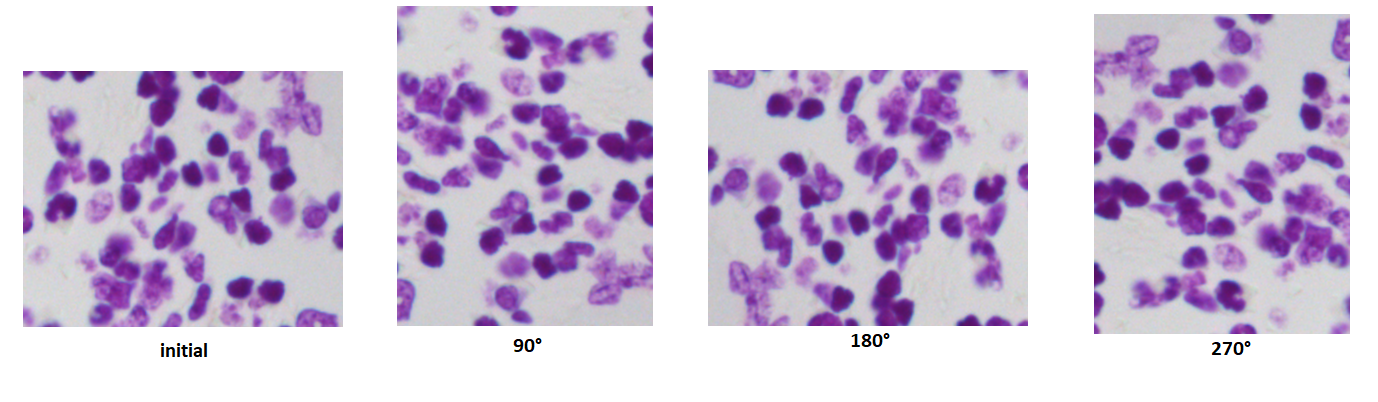

In [ ]:
import os
import cv2
import numpy as np
from numpy.random import randint
import random

rgb_path = TRAIN_PATH+"image"

gt_path = TRAIN_PATH+"mask"



def flip(rgb_path,  gt_path):
    rgb_images = os.listdir(rgb_path)
    
    gt_images = os.listdir(gt_path)

    entries = list(zip(rgb_images, gt_images))
    total = len(entries)
    actuel = 1

    for entry in entries:

        rgb = cv2.imread(rgb_path + "/" + entry[0], cv2.IMREAD_UNCHANGED)
        
        gt = cv2.imread(gt_path + "/" + entry[1], cv2.IMREAD_UNCHANGED)
        # rotation 90 degres rgb depth gt (clockwise)
        img_rotate_90 = cv2.rotate(rgb, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(rgb_path + "/flip90" + entry[0], img_rotate_90)

        

        gt_rotate_90 = cv2.rotate(gt, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(gt_path + "/flip90" + entry[1], gt_rotate_90)

        # rotation 270 degres rgb depth gt (clockwise)
        img_rotate_270 = cv2.rotate(rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(rgb_path + "/flip270" + entry[0], img_rotate_270)

       

        gt_rotate_270 = cv2.rotate(gt, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(gt_path + "/flip270" + entry[1], gt_rotate_270)

        # rotation 180 degres rgb depth gt (clockwise)
        img_rotate_180 = cv2.rotate(rgb, cv2.ROTATE_180)
        cv2.imwrite(rgb_path + "/flip180" + entry[0], img_rotate_180)

        gt_rotate_180 = cv2.rotate(gt, cv2.ROTATE_180)
        cv2.imwrite(gt_path + "/flip180" + entry[1], gt_rotate_180)

        print(str(actuel)+"/"+str(total))
        actuel += 1
    print("fin")

flip(rgb_path, gt_path)



print("fin de la data augment")

1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/500
139/

# CREATION DU MODEL

In [ ]:
class Custom_Generator(tf.keras.utils.Sequence):
    def __init__(self, rgb_path, gt_path, batch_size):
        self.batch_size = batch_size
        self.length = len(os.listdir(rgb_path))

        self.rgb_path = rgb_path
        
        self.gt_path = gt_path
        self.indexes = np.arange(self.length)
        self.on_epoch_end()

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.length / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        x = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, 3))
        
        y = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH))

        cpt = 0

        for i in indexes:
            rgb_input = cv.imread(self.rgb_path + "/" + os.listdir(self.rgb_path)[i])
            rgb_input= cv.resize(rgb_input, (128, 128))/255
            gt_input = cv.imread(self.gt_path + "/" + os.listdir(self.gt_path)[i], 0)
            gt_input =  cv.resize(gt_input, (128, 128))/255
            x[cpt, ] = rgb_input

            y[cpt, ] = gt_input

            cpt += 1
        return x, y


## la fonction de perte:
la fonction de perte utilisée est la fonction dice loss qui a été résenté à la communauté de la vision par ordinateur en 2016 pour la segmentation d'images médicales 3D.

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (k.sum(y_true_f) + k.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


## U-NET
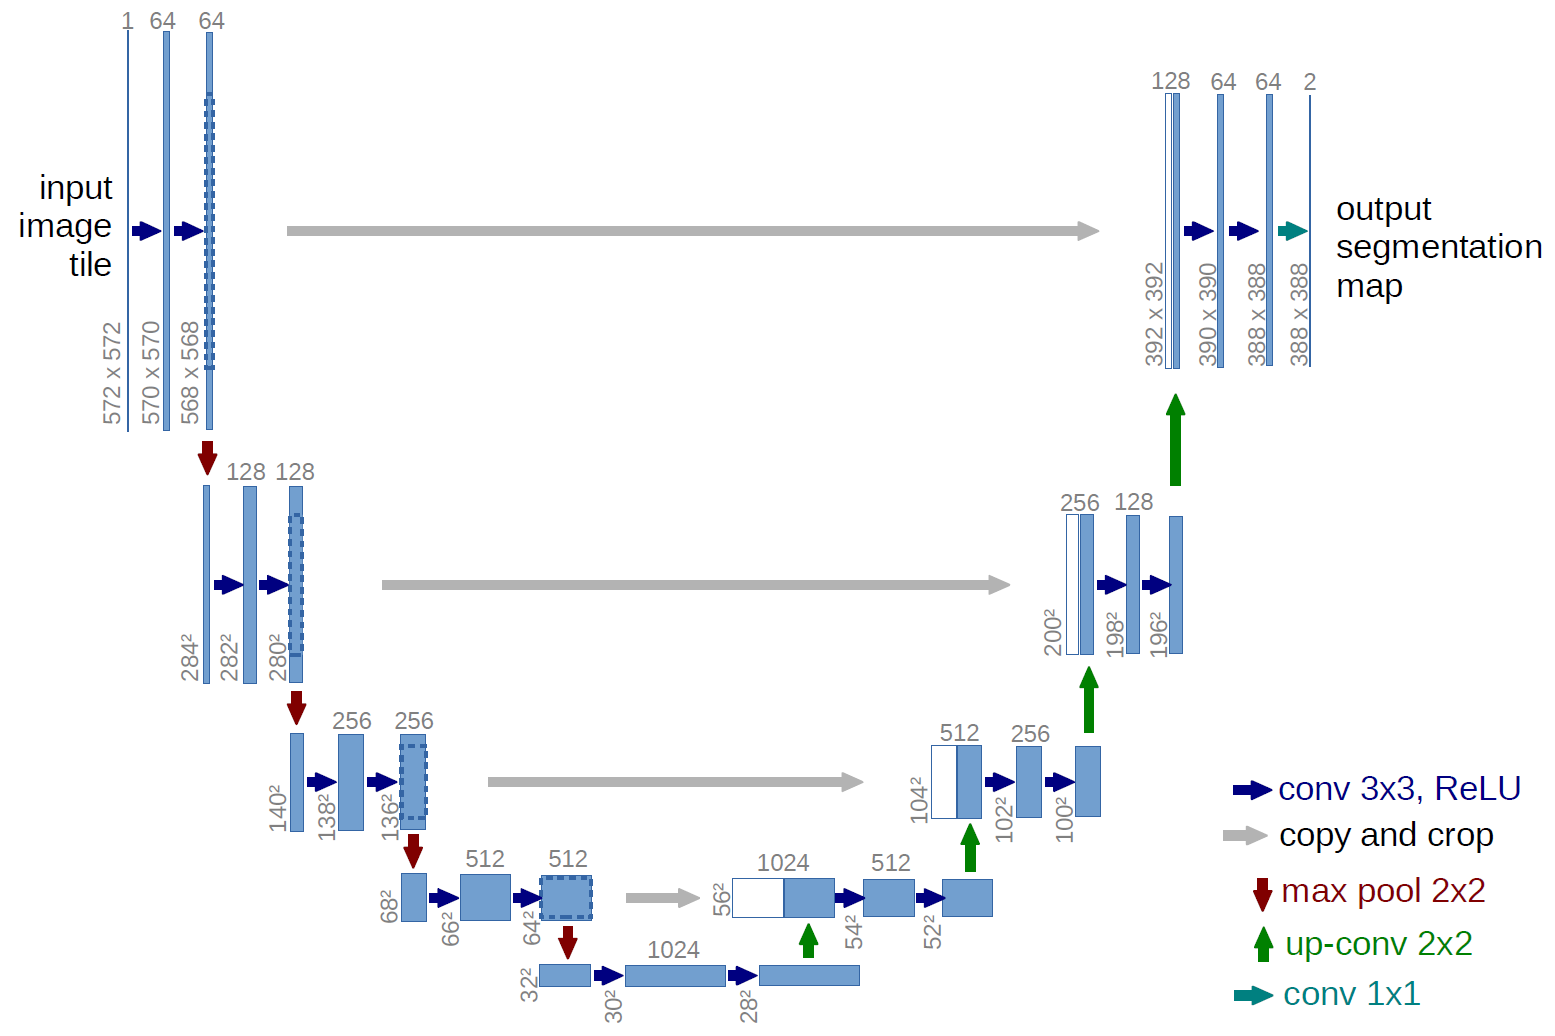

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.5)(p1)
p1 = BatchNormalization()(p1)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.5)(p2)
p2 = BatchNormalization()(p2)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.5)(p3)
p3 = BatchNormalization()(p3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.5)(p4)
p4 = BatchNormalization()(p4)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#binary_crossentropy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=dice_coef_loss, metrics=[dice_coef,keras.metrics.binary_accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## exécution sur GPU

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)
LR_Scheduler_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='min',
                                                      min_delta=0.1, cooldown=1, min_lr=0)
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Entrainement du Model:

In [ ]:
results = model.fit_generator(Custom_Generator(TRAIN_PATH+"image",TRAIN_PATH+"mask",20), validation_data=Custom_Generator(TEST_PATH+"image",TEST_PATH+"mask",1), validation_steps=1, 
                              steps_per_epoch=int(np.floor((len(os.listdir(TRAIN_PATH+"image")) / 20)),),
                              epochs=20,
                               callbacks = [checkpointer])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 45s 101ms/step - loss: 0.5645 - dice_coef: 0.4355 - binary_accuracy: 0.6820 - val_loss: 0.8322 - val_dice_coef: 0.1678 - val_binary_accuracy: 0.8817

Epoch 00001: val_loss improved from inf to 0.83218, saving model to model-dsbowl2018-1.h5
Epoch 2/20
100/100 [==============================] - 9s 95ms/step - loss: 0.4252 - dice_coef: 0.5748 - binary_accuracy: 0.7967 - val_loss: 0.9926 - val_dice_coef: 0.0074 - val_binary_accuracy: 0.6637

Epoch 00002: val_loss did not improve from 0.83218
Epoch 3/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2612 - dice_coef: 0.7388 - binary_accuracy: 0.9160 - val_loss: 0.9971 - val_dice_coef: 0.0029 - val_binary_accuracy: 0.6633

Epoch 00003: val_loss did not improve from 0.83218
Epoch 4/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2641 - dice_coef: 0.7359 - binary_accuracy: 0.9185 - val_loss: 0.9418 - val_dice_coef: 0.0582 - val_binary_accuracy: 0.67

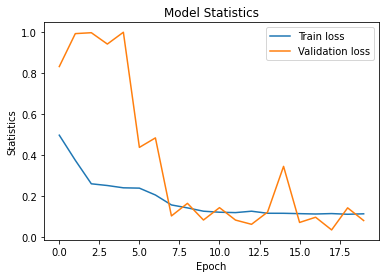

In [ ]:
def model_results(history):

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label = 'Train loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')

    #plt.plot(history.history['dice_coef'], label = 'Train dice ')
   # plt.plot(history.history['val_dice_coef'], label = 'Validation dice ')

    plt.legend(loc="best")
    plt.title('Model Statistics')
    plt.ylabel('Statistics')
    plt.xlabel('Epoch')
    
    plt.show()
model_results(results)

In [ ]:

model.load_weights("model-dsbowl2018-1.h5")


# Visualisation des résultats

Extraction du 2eme jeu de données

In [ ]:
from google.colab.patches import cv2_imshow
if not os.path.exists("./test"):
  !mkdir ./test
  !mkdir ./stage1_test
TEST="./test/"

import zipfile
with zipfile.ZipFile("./stage1_test.zip", 'r') as zip_ref:

    zip_ref.extractall("./stage1_test")

#creation des images et masks

for folder in os.listdir("./stage1_test"):
  shutil.copyfile("./stage1_test/"+folder+"/images/"+folder+".png",TEST+folder+".png")
  

on prend une image au hasard du 2eme jeu de données pour lui faire la segmentation

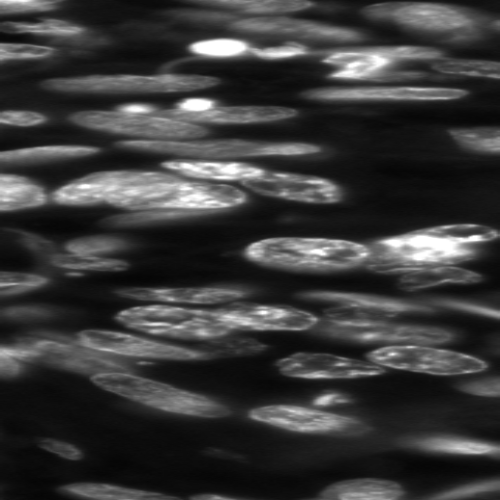

In [ ]:
test_image=os.listdir("./test")
path="./test/"+test_image[random.randint(0,len(test_image))]
img=cv.imread(path)
cv2_imshow(cv.resize(img,(500,500)))
img=cv.resize(img,(128,128))/255
img = np.expand_dims(img, axis=0)

resultat=model.predict(img)*255


In [ ]:
taille=(500,500)

img=cv.resize(resultat[0,:,:,:],taille)

cv.imwrite("1.png",img)

True

resultat de la segmentation

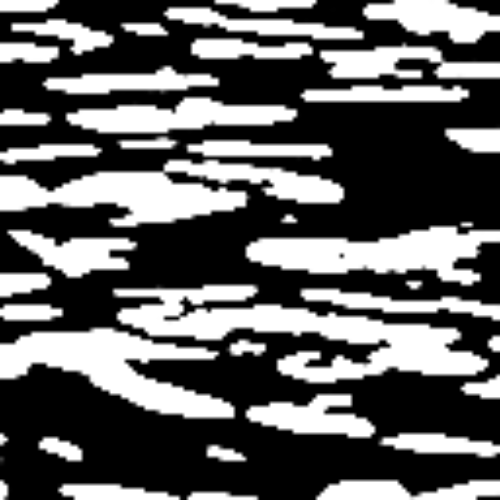

In [ ]:
init=cv.imread(path)
init=cv.resize(init,taille)
image = cv.imread('1.png')
mix=cv.addWeighted(init,0.5,image,0.5,0)
cv2_imshow(image)

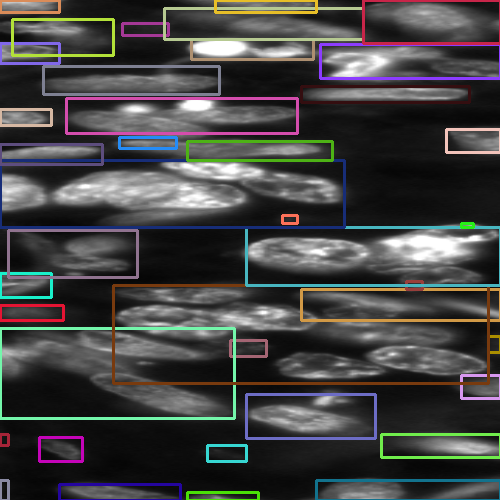

In [ ]:

copy = image.copy()
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray,0,255,cv.THRESH_OTSU + cv.THRESH_BINARY)[1]

cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    cv.rectangle(init,(x,y),(x+w,y+h),(random.randint(0,255),random.randint(0,255),random.randint(0,255)),2)
    

cv2_imshow( init)
